Over the past few years, streaming services with huge catalogs have become the primary means through which most people listen to their favorite music. But at the same time, the sheer amount of music on offer can mean users might be a bit overwhelmed when trying to look for newer music that suits their tastes.

For this reason, streaming services have looked into means of categorizing music to allow for personalized recommendations. One method involves direct analysis of the raw audio information in a given song, scoring the raw data on a variety of metrics. Today, we'll be examining data compiled by a research group known as The Echo Nest. Our goal is to look through this dataset and classify songs as being either 'Hip-Hop' or 'Rock' - all without listening to a single one ourselves. In doing so, we will learn how to clean our data, do some exploratory data visualization, and use feature reduction towards the goal of feeding our data through some simple machine learning algorithms, such as decision trees and logistic regression.

To begin with, let's load the metadata about our tracks alongside the track metrics compiled by The Echo Nest. A song is about more than its title, artist, and number of listens. We have another dataset that has musical features of each track such as danceability and acousticness on a scale from -1 to 1. These exist in two different files, which are in different formats - CSV and JSON. While CSV is a popular file format for denoting tabular data, JSON is another common file format in which databases often return the results of a given query.

Let's start by creating two pandas DataFrames out of these files that we can merge so we have features and labels (often also referred to as X and y) for the classification later on.

In [390]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.pipeline import Pipeline, make_pipeline
import matplotlib.colors
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [391]:
# Read in track metadata with genre labels
tracks = pd.read_csv('C:/Users/HP/Desktop/data/fma-rock-vs-hiphop.csv')

# Read in track metrics with the features
echonest_metrics = pd.read_json('C:/Users/HP/Desktop/data/echonest-metrics.json', precise_float=True)

# Merge the relevant columns of tracks and echonest_metrics
df = echonest_metrics.merge(tracks[['genre_top', 'track_id']], on='track_id')

# Inspect the resultant dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


In [392]:
# print summary statistics
df.describe()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
count,4802.000000,4.802000e+03,4802.000000,4802.000000,4802.000000,4802.000000,4802.000000,4802.000000,4802.000000
mean,30164.871720,4.870600e-01,0.436556,0.625126,0.604096,0.187997,0.104877,126.687944,0.453413
std,28592.013796,3.681396e-01,0.183502,0.244051,0.376487,0.150562,0.145934,34.002473,0.266632
min,2.000000,9.491000e-07,0.051307,0.000279,0.000000,0.025297,0.023234,29.093000,0.014392
25%,7494.250000,8.351236e-02,0.296047,0.450757,0.164972,0.104052,0.036897,98.000750,0.224617
50%,20723.500000,5.156888e-01,0.419447,0.648374,0.808752,0.123080,0.049594,124.625500,0.446240
75%,44240.750000,8.555765e-01,0.565339,0.837016,0.915472,0.215151,0.088290,151.450000,0.666914
max,124722.000000,9.957965e-01,0.961871,0.999768,0.993134,0.971392,0.966177,250.059000,0.983649


Tempo has high variance. 

In [393]:
print(df['genre_top'].value_counts())

Rock       3892
Hip-Hop     910
Name: genre_top, dtype: int64


#### NOTE:
This clearly shows that the dataset is imbalanced. Hence, accuracy may not be the best metric to evaluate the model performance. Therefore, we may need to look at other metrics such as **precision** and **f1_score** .

### 2. Pairwise relationships between continuous variables
 We typically want to avoid using variables that have strong correlations with each other -- hence avoiding feature redundancy -- for a few reasons:

* To keep the model simple and improve interpretability (with many features, we run the risk of overfitting).
* When our datasets are very large, using fewer features can drastically speed up our computation time.

To get a sense of whether there are any strongly correlated features in our data, we will plot the heatmap using seaborn library.

In [394]:
# Custom colour map based on Netflix palette
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#221f1f', '#0045a4','#0e4f66'])
def genreHeatmap():  
    test = echonest_metrics
    corr = test.corr()
    mask = np.zeros_like(corr, dtype= bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(10, 7), dpi = 100)
    fig.text(.37, .95,'Correlation Coefficient', fontfamily='serif',fontweight='bold',fontsize=15)
    pl = sns.heatmap(corr, mask=mask, annot = True, fmt = '.2f',cbar = False,
                     cmap=cmap, vmax=.3, vmin=-.3, center=0, square=True, linewidths=2.5)
    plt.tick_params(which=u'both', axis=u'both', length=0)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

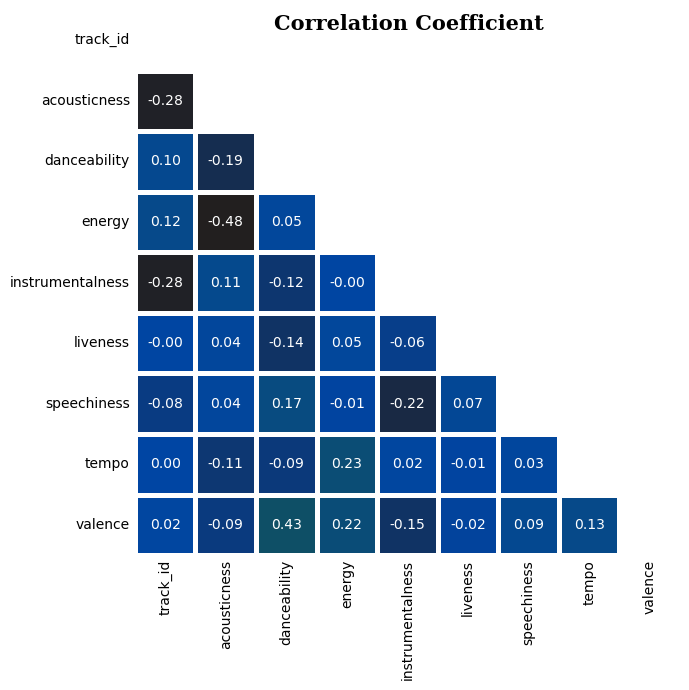

In [395]:
genreHeatmap()

From the above heatmap, it appears that there is no strong correleation between the features

### 3. Splitting our data

As mentioned earlier, it can be particularly useful to simplify our models and use as few features as necessary to achieve the best result. Since we didn't find any particularly strong correlations between our features, we can now split our data into an array containing our features, and another containing the labels - the genre of the track.

Once we have split the data into these arrays, we will perform some preprocessing steps to optimize our model development.


In [396]:
# Create features
features = echo_tracks.drop(["genre_top", "track_id"], axis=1)

# Create labels
labels = echo_tracks["genre_top"]

# Split our data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state=42)

### Normalizing the feature data
As mentioned earlier, it can be particularly useful to simplify our models and use as few features as necessary to achieve the best result. Since we didn't find any particular strong correlations between our features, we can instead use a common approach to reduce the number of features called principal component analysis (PCA).

It is possible that the variance between genres can be explained by just a few features in the dataset. PCA rotates the data along the axis of highest variance, thus allowing us to determine the relative contribution of each feature of our data towards the variance between classes.

However, since PCA uses the absolute variance of a feature to rotate the data, a feature with a broader range of values will overpower and bias the algorithm relative to the other features. To avoid this, we must first normalize our train and test features. There are a few methods to do this, but a common way is through standardization, such that all features have a mean = 0 and standard deviation = 1 (the resultant is a z-score). 

In [397]:
# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Scale X_train and set the values to a new variable
scaler = StandardScaler()

# Scale train_features and test_features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 5. Principal Component Analysis on our scaled data

Now that we have preprocessed our data, we are ready to use PCA to determine by how much we can reduce the dimensionality of our data. We can use **scree-plots** and **cumulative explained ratio plots** to find the number of components to use in further analyses.

Scree-plots display the number of components against the variance explained by each component, sorted in descending order of variance. Scree-plots help us get a better sense of which components explain a sufficient amount of variance in our data. When using scree plots, an 'elbow' (a steep drop from one data point to the next) in the plot is typically used to decide on an appropriate cutoff.


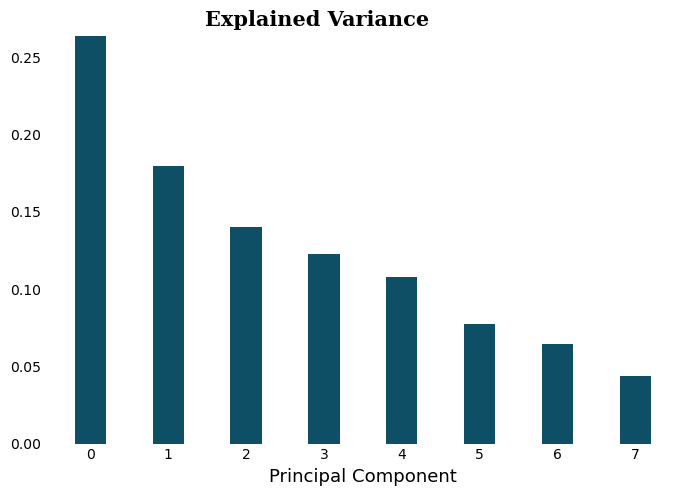

In [398]:
from sklearn.decomposition import PCA

# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(X_test_scaled)
exp_variance = pca.explained_variance_ratio_

# plot the explained variance using a barplot
fig, ax = plt.subplots(figsize = (7, 5), dpi=100)
ax.bar(range(pca.n_components_), exp_variance, width=0.4, color='#0e4f66')

# Label x-axis
ax.set_xlabel('Principal Component', fontsize=13)

# Remove the borders
for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    
# Add title
fig.text(0.3, 0.95, 'Explained Variance', fontsize =15, 
         fontfamily='serif', fontweight='bold')

plt.tick_params(axis=u'both', which = u'both', length=0)
plt.tight_layout()

# Show the plot
plt.show()

### 6. Further visualization of PCA

Unfortunately, there does not appear to be a clear elbow in this scree plot, which means it is not straightforward to find the number of intrinsic dimensions using this method.

But all is not lost! Instead, we can also look at the **cumulative explained variance plot** to determine how many features are required to explain, say, about 85% of the variance (cutoffs are somewhat arbitrary here, and usually decided upon by 'rules of thumb'). Once we determine the appropriate number of components, we can perform PCA with that many components, ideally reducing the dimensionality of our data.


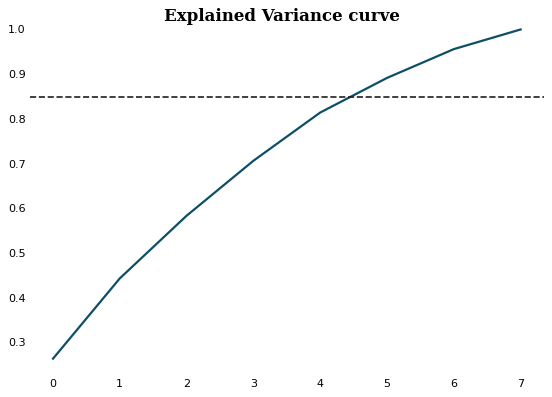

In [399]:
# plot the explained variance using a barplot
fig, ax = plt.subplots(figsize = (7, 5), dpi=80)

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.85.
ax.plot(cum_exp_variance, color = '#0e4f66', linewidth=2.0 )
ax.axhline(y=0.85, linestyle='--', color = '#221f1f')

# Remove the borders
for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    
# Add title
fig.text(0.3, 0.95, 'Explained Variance curve', fontsize =15, 
         fontfamily='serif', fontweight='bold')

plt.tick_params(axis=u'both', which = u'both', length=0)
plt.tight_layout()

# Show the plot
plt.show()

### 7. Projecting on to our features
We saw from the plot that 6 features (remember indexing starts at 0) can explain 85% of the variance!
Therefore, we can use 6 components to perform PCA and reduce the dimensionality of our train and test features.


In [400]:
# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components=6, random_state=42)

# Fit and transform the scaled training features using pca
train_pca = pca.fit_transform(X_train_scaled)

# Fit and transform the scaled test features using pca
test_pca = pca.transform(X_test_scaled)

### 8. Train a decision tree to classify genre
Now we can use the lower dimensional PCA projection of the data to classify songs into genres.

Here, we will be using a simple algorithm known as a decision tree. Decision trees are rule-based classifiers that take in features and follow a 'tree structure' of binary decisions to ultimately classify a data point into one of two or more categories. In addition to being easy to both use and interpret, decision trees allow us to visualize the 'logic flowchart' that the model generates from the training data.

Here is an example of a decision tree that demonstrates the process by which an input image (in this case, of a shape) might be classified based on the number of sides it has and whether it is rotated.

In [401]:
# Create our decision tree
dt = DecisionTreeClassifier(random_state=42)

# Train our decision tree
dt.fit(train_pca, y_train)

# Predict the labels for the test data
dt_pred = dt.predict(test_pca)

### 9. Compare our decision tree to other algorithms

Although our tree's performance is decent, it's a bad idea to immediately assume that it's therefore the perfect tool for this job -- there's always the possibility of other models that will perform even better! It's always a worthwhile idea to at least test a few other algorithms and find the one that's best for our data.

Sometimes simplest is best, and so we will start by applying **logistic regression**. Logistic regression makes use of what's called the logistic function to calculate the odds that a given data point belongs to a given class. Once we have both models, we can compare them on a few performance metrics, such as false positive and false negative rate (or how many points are inaccurately classified).


In [402]:
# Train our logisitic regression
lr = LogisticRegression(random_state=42)
lr.fit(train_pca, y_train)
lr_pred = lr.predict(test_pca)

In [403]:
# Train our logisitic regression
rf = RandomForestClassifier(random_state=42)
rf.fit(train_pca, y_train)
rf_pred = rf.predict(test_pca)

In [404]:
# Train our logisitic regression
svm =SVC(random_state=42)
svm.fit(train_pca, y_train)
svm_pred = svm.predict(test_pca)

In [405]:
class_rep_tree = classification_report(y_test, dt_pred)
class_rep_log = classification_report(y_test, lr_pred)
class_rep_forest =classification_report(y_test, rf_pred)
class_rep_svc = classification_report(y_test, svm_pred)


In [406]:
print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)
print("Random Forest: \n", class_rep_forest)
print("Support Vector: \n", class_rep_svc)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.66      0.65      0.65       182
        Rock       0.92      0.92      0.92       779

    accuracy                           0.87       961
   macro avg       0.79      0.79      0.79       961
weighted avg       0.87      0.87      0.87       961

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.76      0.54      0.63       182
        Rock       0.90      0.96      0.93       779

    accuracy                           0.88       961
   macro avg       0.83      0.75      0.78       961
weighted avg       0.87      0.88      0.87       961

Random Forest: 
               precision    recall  f1-score   support

     Hip-Hop       0.88      0.69      0.77       182
        Rock       0.93      0.98      0.95       779

    accuracy                           0.92       961
   macro avg       0.90      0.83      0.86       961
weighted avg     

### 10. Balance our data for greater performance

Our models do similarly well. However, looking at our classification report, we can see that rock songs are fairly well classified, but hip-hop songs are disproportionately misclassified as rock songs.

Why might this be the case? Well, just by looking at the number of data points we have for each class, we see that we have far more data points for the rock classification than for hip-hop, potentially skewing our model's ability to distinguish between classes. This also tells us that most of our model's accuracy is driven by its ability to classify just rock songs, which is less than ideal.

To account for this, we can weight the value of a correct classification in each class inversely to the occurrence of data points for each class. Since a correct classification for "Rock" is not more important than a correct classification for "Hip-Hop" (and vice versa), we only need to account for differences in sample size of our data points when weighting our classes here, and not relative importance of each class.


In [407]:
# Subset a balanced proportion of data points
hop_only = df.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = df.loc[echo_tracks['genre_top'] == 'Rock']

# subset only the rock songs, and take a sample the same size as there are hip-hop songs
rock_only = rock_only.sample(hop_only.shape[0], random_state=42)

# concatenate the dataframes hop_only and rock_only
rock_hop_bal = pd.concat([rock_only, hop_only])

In [408]:
# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']

# Redefine the train and test set with the pca_projection from the balanced data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

train_pca = pca.fit_transform(scaler.fit_transform(X_train))
test_pca = pca.transform(scaler.transform(X_test))

### 11. Does balancing our dataset improve model bias?

We've now balanced our dataset, but in doing so, we've removed a lot of data points that might have been crucial to training our models. Let's test to see if balancing our data improves model bias towards the "Rock" classification while retaining overall classification performance.


In [409]:
# Create our decision tree
dt = DecisionTreeClassifier(random_state=42)
# Train our decision tree
dt.fit(train_pca, y_train)

# Predict the labels for the test data
dt_pred = dt.predict(test_pca)

In [410]:
# Train our logisitic regression
lr = LogisticRegression(random_state=42)
lr.fit(train_pca, y_train)

# Predict the labels for the test data
lr_pred = lr.predict(test_pca)

In [411]:
# Train our logisitic regression
rf = RandomForestClassifier(random_state=42)
rf.fit(train_pca, y_train)

# Predict the labels for the test data
rf_pred = rf.predict(test_pca)

In [412]:
# Train our logisitic regression
svm = LogisticRegression(random_state=42)
svm.fit(train_pca, y_train)

# Predict the labels for the test data
svm_pred = svm.predict(test_pca)

In [413]:
class_rep_tree = classification_report(y_test, dt_pred)
class_rep_log = classification_report(y_test, lr_pred)
class_rep_forest =classification_report(y_test, rf_pred)
class_rep_svc = classification_report(y_test, svm_pred)

In [414]:
print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)
print("Random Forest: \n", class_rep_forest)
print("Support Vector: \n", class_rep_svc)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.79      0.80      0.80       183
        Rock       0.79      0.79      0.79       181

    accuracy                           0.79       364
   macro avg       0.79      0.79      0.79       364
weighted avg       0.79      0.79      0.79       364

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.81      0.83       183
        Rock       0.82      0.84      0.83       181

    accuracy                           0.83       364
   macro avg       0.83      0.83      0.83       364
weighted avg       0.83      0.83      0.83       364

Random Forest: 
               precision    recall  f1-score   support

     Hip-Hop       0.86      0.85      0.85       183
        Rock       0.85      0.86      0.85       181

    accuracy                           0.85       364
   macro avg       0.85      0.85      0.85       364
weighted avg     

### 12. Using cross-validation to evaluate our models
Before we can perform cross-validation we will need to create pipelines to scale our data, perform PCA, and instantiate our model of choice - DecisionTreeClassifier or LogisticRegression or RandomForest or SVC

Since the way our data is split into train and test sets can impact model performance, CV attempts to split the data multiple ways and test the model on each of the splits. Although there are many different CV methods, all with their own advantages and disadvantages, we will use what's known as K-fold CV here. K-fold first splits the data into K different, equally sized subsets. Then, it iteratively uses each subset as a test set while using the remainder of the data as train sets. Finally, we can then aggregate the results from each fold for a final model performance score.


In [415]:
dt_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                      ("tree", DecisionTreeClassifier(random_state=42))])
lr_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                        ("logreg", LogisticRegression(random_state=42))])
rf_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                        ("classifier", RandomForestClassifier(random_state=42))])
svm_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                        ("svm", SVC(random_state=42))])

# Set up our K-fold cross-validation
kf = KFold(10)


In [416]:
# Train our models using KFold cv
dt_score = cross_val_score(dt_pipe, features, labels, cv=kf)
lr_score = cross_val_score(lr_pipe, features, labels, cv=kf)
rf_score = cross_val_score(rf_pipe, features, labels, cv=kf)
svm_score = cross_val_score(svm_pipe, features, labels, cv=kf)

In [417]:
score_df = pd.DataFrame(data=[round(np.mean(dt_score),3), 
                              round(np.mean(lr_score), 3),
                              round(np.mean(rf_score), 3),
                              round(np.mean(svm_score), 3)],
                    columns = ['model_scores'],
                    index = ['Decision tree', 'Logistic regression', 
                             'Random forest', 'Support vector'])

In [418]:
score_df

,model_scores
Decision tree,0.732
Logistic regression,0.775
Random forest,0.810
Support vector,0.818


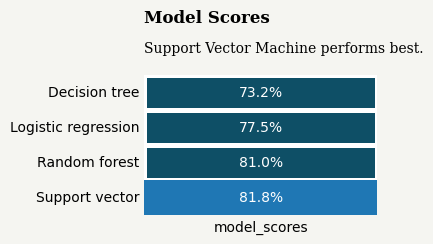

In [422]:
fig = plt.figure(figsize=(3, 10), dpi = 100)
f = fig.add_gridspec(4, 2)
f.update(wspace=0.1, hspace=0.5)
ax = fig.add_subplot(f[0, :])

colors = ['#0e4f66', '#0e4f66']
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
# Change background color
background_color = '#f5f5f1'

# figure background color
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

sns.heatmap(score_df, cmap=cmap,annot=True,fmt=".1%", linewidths=2.5,cbar=False,ax=ax)


ax.tick_params(axis=u'both', which=u'both',length=0)
ax.text(0,-1.5,'Model Scores',fontfamily='serif',fontsize=12,fontweight='bold')
ax.text(0,-0.65,'Support Vector Machine performs best.',
         fontfamily='serif',fontsize=10)

from matplotlib.patches import Rectangle
rect = ax.add_patch(Rectangle((0, 3), 5, 1, fill=True, edgecolor='black', lw=0))

plt.show()

### Confusion Matrix

In [420]:
def  plot_conf_matrix(y_test, y_pred, labels, ax):
    """This function plot the confusion matrix"""
    
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=labels)
    cmap = plt.cm.Blues
    g = disp.plot(ax=ax, colorbar=False, cmap = cmap)
    g = fig.text(0.35, 1, "Confusion Matrix", fontfamily="serif", fontweight='bold', fontsize=15)
    return g
                              

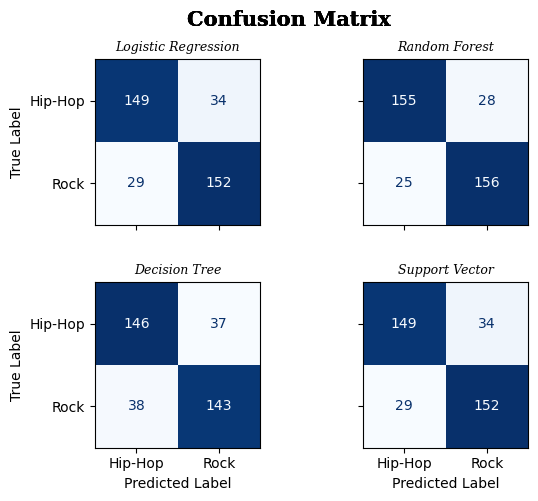

In [421]:
fig, ax = plt.subplots(2, 2, sharey = True, sharex=True)
plot_conf_matrix(y_test, lr_pred, labels= lr.classes_, ax=ax[0, 0])
ax[0,0].set_title("Logistic Regression", fontsize = 9, fontfamily ='serif', fontstyle = 'italic')
plot_conf_matrix(y_test, rf_pred, labels= rf.classes_, ax=ax[0, 1])
ax[0,1].set_title("Random Forest", fontsize = 9, fontfamily ='serif', fontstyle = 'italic')
plot_conf_matrix(y_test, dt_pred, labels= dt.classes_, ax=ax[1, 0])
ax[1,0].set_title("Decision Tree", fontsize = 9, fontfamily ='serif', fontstyle = 'italic')
plot_conf_matrix(y_test, svm_pred, labels= svm.classes_, ax=ax[1, 1])
ax[1,1].set_title("Support Vector", fontsize = 9, fontfamily ='serif', fontstyle = 'italic')
fig.tight_layout()

# Label axes
for i in ax.flat:
    i.set(xlabel = 'Predicted Label', ylabel = 'True Label')
    
# Hide x labels and tick labels for top plots and y_ticks for right plots.
for i in ax.flat:
    i.label_outer()
    
# Show the plot
plt.show()

Support vector machine is the best model.